In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
import pandas_datareader.data as web
stock = ["AAPL", "AMZN", "FB", "GOOG", "MSFT", "NFLX"]
data = web.DataReader(stock,data_source="yahoo",start='29/11/2018')['Adj Close']

In [3]:
data.head()

Symbols,AAPL,AMZN,FB,GOOG,MSFT,NFLX
Date,,,,,,
2018-11-28,178.261627,1677.750000,136.759995,1086.229980,109.500916,282.649994
2018-11-29,176.892197,1673.569946,138.679993,1088.300049,108.584465,288.750000
2018-11-30,175.936554,1690.170044,140.610001,1094.430054,109.274261,286.130005
2018-12-03,182.084183,1772.359985,141.089996,1106.430054,110.456779,290.299988
2018-12-04,174.074539,1668.400024,137.929993,1050.819946,106.938789,275.329987


In [4]:
# Plotly graph
'''import plotly.graph_objects as go
fig = go.Figure()
idx = 0
for i in data.columns:
    fig.add_trace(go.Scatter(x=data.index, y=data[stock[idx]], name=stock[idx]))
    idx += 1
fig.update_layout(yaxis_title="Price in $")
fig.show()'''

'import plotly.graph_objects as go\nfig = go.Figure()\nidx = 0\nfor i in data.columns:\n    fig.add_trace(go.Scatter(x=data.index, y=data[stock[idx]], name=stock[idx]))\n    idx += 1\nfig.update_layout(yaxis_title="Price in $")\nfig.show()'

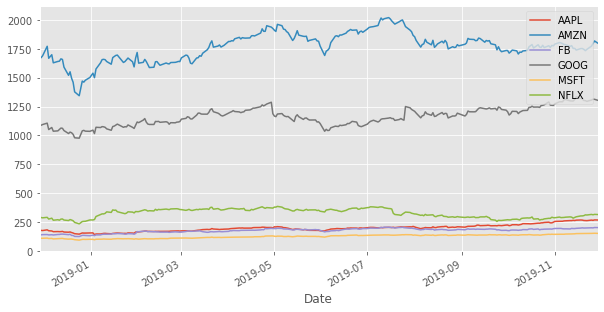

In [5]:
data.plot(figsize=(10,5))
plt.legend(loc="upper right")
plt.show()

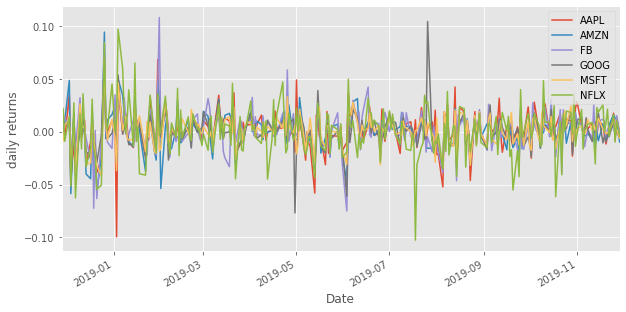

In [6]:
returns = data.pct_change()
returns.plot(figsize=(10,5))
plt.ylabel("daily returns")
plt.legend(loc="upper right")
plt.show()

In [7]:
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights)*252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))*np.sqrt(252)
    return std, returns

In [8]:
def random_portfolios(num_portfolio, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolio))
    weights_record = []
    for i in range(num_portfolio):
        weights = np.random.random(len(stock))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return-risk_free_rate)/portfolio_std_dev
    return results, weights_record

In [9]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolio = 10000
risk_free_rate = 0.0178

In [10]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate):
    results, weights = random_portfolios(num_portfolio, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=data.columns,columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100,2) for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print(max_sharpe_allocation)
    print("\n")
    print("Minimum Volatility Portfolio Allocation")
    print("Annualized Return:", round(rp_min,2))
    print("Annualized Volatility:", round(sdp_min,2))
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(results[0,:], results[1,:], c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min,marker='*',color='g', s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized returns')
    plt.legend(labelspacing=0.8)

Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.4
Annualized Volatility: 0.23
Symbols      AAPL  AMZN     FB  GOOG   MSFT  NFLX
allocation  37.15  1.67  26.37  0.72  34.02  0.07


Minimum Volatility Portfolio Allocation
Annualized Return: 0.31
Annualized Volatility: 0.22
Symbols     AAPL  AMZN     FB   GOOG   MSFT  NFLX
allocation  0.88  2.69  15.81  31.51  46.96  2.15


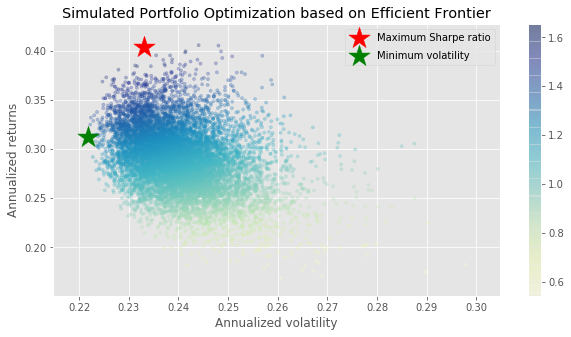

In [11]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate)

In [16]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate)/p_var

import scipy.optimize as sco

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [26]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [27]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualized_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result

def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

In [34]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualized_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe['x'], index=data.columns, columns=['allocation'])
    max_sharpe_allocation['allocation'] = [round(i*100, 2)for i in max_sharpe_allocation['allocation']]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualized_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=data.columns,columns=['allocation'])
    min_vol_allocation['allocation'] = [round(i*100,2)for i in min_vol_allocation['allocation']]
    min_vol_allocation = min_vol_allocation.T
    
    print("Maximum Sharpe Ratio Portfolio Allocation")
    print("Annualized Return:", round(rp,2))
    print("Annualized Volatility:", round(sdp,2))
    print(max_sharpe_allocation)
    print("Minimum Volatility Portfolio Allocation")
    print("Annualized Return:", round(rp_min, 2))
    print("Annualized Volatility:", round(sdp_min, 2))
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(results[0,:], results[1,:], c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*', color='r', s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min, rp_min, marker='*', color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([pf['fun'] for pf in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualized volatility')
    plt.ylabel('Annualized returns')
    plt.legend(labelspacing=0.8)

In [ ]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolio, risk_free_rate)

Maximum Sharpe Ratio Portfolio Allocation
Annualized Return: 0.41
Annualized Volatility: 0.23
Symbols     AAPL  AMZN     FB  GOOG   MSFT  NFLX
allocation  38.5   0.0  27.41   0.0  34.09   0.0
Minimum Volatility Portfolio Allocation
Annualized Return: 0.33
Annualized Volatility: 0.22
Symbols     AAPL  AMZN    FB   GOOG  MSFT  NFLX
allocation  7.97   0.0  9.19  23.75  59.1   0.0
